In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import numpy as np 
%matplotlib inline

In [2]:
from scipy.special import expit
class NumpyClassifier():
    """Common methods to """

    def accuracy(self, X_test, y_test, **kwargs):
        pred = self.predict(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:, 0]
        return sum(pred == y_test) / len(pred)


class NumpyLogReg(NumpyClassifier):
    def __init__(self, eta = None, lmb = None) -> None:
        super().__init__()
        self.eta = eta
        self.lmb = lmb



    def fit(self, X_train, t_train,batch_size, epochs, solver = "SGD"):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        m = X_train.shape[1]
        n_batches = np.ceil(X_train.shape[0] / batch_size)

      
        self.beta =  np.zeros(m)
        
        indicies = np.arange(X_train.shape[0])
        if solver == "SGD":
            #Stochastic Gradient Descent:
            print("Solving with SGD")

            for epoch in range(epochs):
                np.random.shuffle(indicies)
                minibatch_list = np.array_split(indicies, n_batches)
                
                for minibatch in (minibatch_list):
                    xi = np.take(X_train, minibatch,axis=0)
                    yi = np.take(t_train, minibatch,axis=0)                
                    p = self.forward(xi)
                    gradient = -xi.T @ (yi-p)
                    
                    #beta punishing 
                    self.beta += self.beta*self.lmb**2
                    #updating betas: 
                    self.beta =self.beta -self.eta*gradient
                    
        elif solver == "NRM":
            #Newton Raphson´s Method:
            print("Solving with NRM")
            for epoch in range(epochs):
                self.newton_raphson(X_train, t_train)
                    
        
        else:
            print("Choose SGM og NRM as solver")   
           

    def forward(self, X):
        return 1/(1+np.exp(-X @ self.beta))
    
    def newton_raphson(self, X,y):
        p = self.forward(X)
        p_1 = 1-p
        score = -X.T @ (y-p)
        
        W = np.zeros(shape=(len(y),len(y)))
        np.fill_diagonal(W,(p*p_1))
        
        hessian = X.T@W@X
        update = np.linalg.pinv(hessian) @ score
        
        self.beta -= update

        
        
    def predict(self, x, threshold=0.5):
        #z = self.add_bias(x)
        score = self.forward(x)
        # score = z @ self.theta
        return (score > threshold).astype('int')


In [3]:
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,test_size=0.25,random_state=4155)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)





Solving with SGD
Solving with SGD
Solving with SGD
Solving with SGD
Solving with SGD
Solving with SGD
Solving with SGD
Solving with SGD
Solving with SGD
Solving with SGD
Solving with SGD
Solving with SGD
Solving with SGD
Solving with SGD
Solving with SGD
Solving with SGD
Solving with SGD
Solving with SGD
Solving with SGD
Solving with SGD


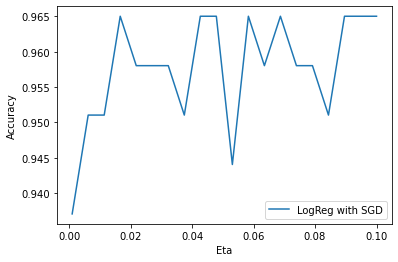

In [4]:

eta_list = np.linspace(0.001,0.1,20)
acu_scores = np.zeros(len(eta_list))
 
cntr = 0
for eta in eta_list:
    logreg_SGD = NumpyLogReg(eta = eta, lmb = 0.1)
    logreg_SGD.fit(X_train_scaled,y_train,batch_size= 5, epochs=1, solver = "SGD")
    score = acu_scores[cntr] = logreg_SGD.accuracy(X_test_scaled, y_test)
    cntr += 1 
    
    
plt.plot(eta_list, acu_scores, label = "LogReg with SGD")
plt.xlabel("Eta")
plt.ylabel("Accuracy")
plt.legend()

In [5]:
logreg_NRM = NumpyLogReg()
logreg_NRM.fit(X_train_scaled,y_train,batch_size= 5, epochs=1, solver = "NRM")
logreg_NRM.accuracy(X_test_scaled, y_test)

Solving with NRM


0.951048951048951

In [6]:
from sklearn.linear_model import LogisticRegression

def sci_kit_test_acu(X_train, X_test, y_train, y_test):
    logreg = LogisticRegression(penalty="l2", C = 0.2)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    

    return sum(y_pred == y_test) / len(y_pred)

sci_kit_test_acu(X_train_scaled, X_test_scaled, y_train, y_test)



0.9790209790209791

### Compare neural network classification results with Logistic regression results:


In [7]:
import numpy as np
import pandas as pd
from imageio import imread
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import os
from common import *
from models import NeuralNetwork, Layer, Fixed_layer, binary_classifier, relu, sigmoid

print(f"Root directory: {os.getcwd()}")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 10,
})

#%matplotlib

Root directory: c:\Users\andre\Dropbox\FYS-STK4155_projects\FYS-STK4155 - Project2\FYS-STK4155-Prj2_report\code


In [8]:
# Hyper parameters
lr = 0.2
epochs = 200
batch_size = 10
hidden1_neurons = 50
input_dim = X_train.shape[1]

# Model architecture
hidden1 = Layer(input_dim, hidden1_neurons, activation="sigmoid", name="hidden1")
hidden2 = Layer(hidden1.neurons, hidden1.neurons*2, activation="sigmoid", name="hidden2")
hidden3 = Layer(hidden2.neurons, hidden2.neurons//2, activation="sigmoid", name="hidden3")
output = Layer(hidden3.neurons, nbf_neurons=1, activation="sigmoid" , name="output")

model = NeuralNetwork(learning_rate=lr, network_type="classification")
model.add(hidden1)
model.add(output)

#TODO: Had to reshape u_train(?)
model.fit(X_train_scaled, y_train.reshape(-1,1), batch_size=batch_size, epochs=epochs)
y_hat = model.predict(X_test_scaled)
y_hat = y_hat.flatten()

def accuracy(y_hat, y_true):
    return np.sum(y_hat == y_true) / y_true.shape[0]

print(accuracy(y_hat,y_test))

0.951048951048951


# With regularization

In [9]:
# Hyper parameters
lmb = 0.0001

# Model architecture
hidden1 = Layer(input_dim, hidden1_neurons, activation="sigmoid", name="hidden1")
hidden2 = Layer(hidden1.neurons, hidden1.neurons*2, activation="sigmoid", name="hidden2")
hidden3 = Layer(hidden2.neurons, hidden2.neurons//2, activation="sigmoid", name="hidden3")
output = Layer(hidden3.neurons, nbf_neurons=1, activation="sigmoid" , name="output")

model = NeuralNetwork(learning_rate=lr , network_type="classification", lmb=lmb)
model.add(hidden1)
model.add(output)

#TODO: Had to reshape u_train(?)
model.fit(X_train_scaled, y_train.reshape(-1,1), batch_size=batch_size, epochs=epochs)
y_hat = model.predict(X_test_scaled)
y_hat = y_hat.flatten()

def accuracy(y_hat, y_true):
    return np.sum(y_hat == y_true) / y_true.shape[0]

print(accuracy(y_hat,y_test))

0.965034965034965
